#  **Pitch Prediction & Optimization Using Machine Learning & Bayesian Inference** 

## ** Overview**
This project builds a **data-driven pitching strategy system** using **Bayesian modeling, Neural Networks, and Reinforcement Learning**. It predicts **optimal pitch locations** and **strike probability** based on **pitcher attributes, batter tendencies, and game context**.

---

## ** Key Features**
###  **Pitch Location Prediction**
- Uses **Bayesian Hierarchical Models** & **Neural Networks** to predict where a pitch should land.
- Factors in **pitch velocity, spin rate, release position, and break movement**.
- Considers **batter weaknesses** like **swing & miss rate, wOBA, and hard-hit percentage**.

###  **Strike Probability Estimation**
- Uses **Bayesian Logistic Regression & Deep Learning Classifiers** to predict **whether a pitch will be a strike**.
- Learns **batter-specific patterns** and **historical pitch outcomes**.

---

## ** Technologies Used**
- **Python** 
- **ML Libraries**: TensorFlow, PyMC3 (Bayesian Modeling), Scikit-Learn  
- **Data Processing**: Pandas, NumPy  
- **Visualization**: Matplotlib, Seaborn  

---

## ** Data Sources**
- **Statcast (MLB Advanced Data)**: Includes pitch velocity, spin rate, release point, movement, and batter statistics.
- **Synthetic Data (For Testing)**: To be used later.

---

## ** Project Goals**
**Predict the best pitch location to maximize strike probability.**  
**Model pitcher-batter interactions using Bayesian inference.**  

---


In [27]:
import requests
import pandas as pd
import numpy as np
import pymc as pm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

print("PyMC Version:", pm.__version__)
print("TensorFlow Version:", tf.__version__)
print("Pandas Version:", pd.__version__)

PyMC Version: 5.12.0
TensorFlow Version: 2.17.0
Pandas Version: 2.2.3


### I see that we can also use PyBaseball package to get the data, but here I am using Requests API to get the data

In [28]:
import requests
import pandas as pd

def get_statcast_data(start_date, end_date, pitcher_id):
    """
    Fetches pitch data from MLB Statcast API via Baseball Savant.
    If the request fails, returns None.
    """
    url = (
        "https://baseballsavant.mlb.com/statcast_search/csv?"
        "all=true&"
        "hfPT=&"              # pitch type filter
        "hfSea=2023&"         # season filter (can be dynamic)
        "hfGT=R|PO|S|E&"      # game type (regular, postseason, spring, etc.)
        f"player_type=pitcher&"
        f"pitcher_lookup%5B%5D={pitcher_id}&"
        f"game_date_gt={start_date}&"    # start date
        f"game_date_lt={end_date}&"      # end date
        "group_by=name"
    )

    response = requests.get(url)
    if response.status_code == 200:
        data = response.content.decode('utf-8')
        # Pandas 2.x supports pd.read_csv(io.StringIO(...)) directly, so we can do:
        from io import StringIO
        df = pd.read_csv(StringIO(data))
        return df
    else:
        print("Error fetching data. Status code:", response.status_code)
        return None

# Example usage
start_date = "2023-04-01"
end_date   = "2023-10-01"
pitcher_id = 594798  # Jacob deGrom
df = get_statcast_data(start_date, end_date, pitcher_id)

if df is not None:
    print(df.head())
else:
    print("No real data available.")

   pitches  player_id     player_name  total_pitches  pitch_percent     ba  \
0     3198     608337  Giolito, Lucas           3326           96.2  0.239   
1     3190     543037    Cole, Gerrit           3628           87.9  0.207   
2     3180     656302    Cease, Dylan           3419           93.0  0.253   
3     3176     668678     Gallen, Zac           4068           78.1  0.235   
4     3166     554430   Wheeler, Zack           3754           84.3  0.228   

     iso  babip    slg   woba  ...  batter_run_value_per_100   xobp   xslg  \
0  0.242  0.275  0.481  0.339  ...                  0.531770  0.317  0.444   
1  0.118  0.262  0.326  0.258  ...                 -1.321160  0.284  0.382   
2  0.159  0.335  0.413  0.326  ...                  0.199560  0.327  0.382   
3  0.144  0.297  0.379  0.288  ...                 -0.905195  0.301  0.427   
4  0.134  0.292  0.362  0.279  ...                 -0.633860  0.280  0.350   

   pitcher_run_value_per_100  xbadiff  xobpdiff  xslgdiff  wob

In [29]:
df.size
df.info()
df.describe()
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 862 entries, 0 to 861
Data columns (total 70 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   pitches                    862 non-null    int64  
 1   player_id                  862 non-null    int64  
 2   player_name                862 non-null    object 
 3   total_pitches              862 non-null    int64  
 4   pitch_percent              862 non-null    float64
 5   ba                         862 non-null    float64
 6   iso                        862 non-null    float64
 7   babip                      862 non-null    float64
 8   slg                        862 non-null    float64
 9   woba                       862 non-null    float64
 10  xwoba                      862 non-null    float64
 11  xba                        862 non-null    float64
 12  hits                       862 non-null    int64  
 13  abs                        862 non-null    int64  

pitches               0
player_id             0
player_name           0
total_pitches         0
pitch_percent         0
                     ..
xobpdiff              0
xslgdiff              0
wobadiff              0
swing_miss_percent    0
arm_angle             0
Length: 70, dtype: int64

In [30]:
df.columns

Index(['pitches', 'player_id', 'player_name', 'total_pitches', 'pitch_percent',
       'ba', 'iso', 'babip', 'slg', 'woba', 'xwoba', 'xba', 'hits', 'abs',
       'launch_speed', 'launch_angle', 'spin_rate', 'velocity',
       'effective_speed', 'whiffs', 'swings', 'takes', 'eff_min_vel',
       'release_extension', 'pos3_int_start_distance',
       'pos4_int_start_distance', 'pos5_int_start_distance',
       'pos6_int_start_distance', 'pos7_int_start_distance',
       'pos8_int_start_distance', 'pos9_int_start_distance', 'pitcher_run_exp',
       'run_exp', 'bat_speed', 'swing_length', 'pa', 'bip', 'singles',
       'doubles', 'triples', 'hrs', 'so', 'k_percent', 'bb', 'bb_percent',
       'api_break_z_with_gravity', 'api_break_z_induced', 'api_break_x_arm',
       'api_break_x_batter_in', 'hyper_speed', 'bbdist', 'hardhit_percent',
       'barrels_per_bbe_percent', 'barrels_per_pa_percent', 'release_pos_z',
       'release_pos_x', 'plate_x', 'plate_z', 'obp', 'barrels_total',
       '

Pitcher-Specific Features
	•	velocity: Pitch speed (MPH).
	•	spin_rate: Ball rotation speed (RPM).
	•	release_extension: Distance from pitcher to plate at release.
	•	arm_angle: Pitcher arm slot during throw.

Pitch Movement & Location
	•	api_break_z_with_gravity: Vertical break after accounting for gravity.
	•	api_break_x_arm: Horizontal movement (from pitcher’s perspective).
	•	release_pos_x, release_pos_z: Release point coordinates.
	•	plate_x, plate_z: Final pitch location at home plate (Target Variables).

Batter Performance Against Pitch
	•	swing_miss_percent: How often the batter misses.
	•	woba, xba, xslg: Expected batting average, slugging.
	•	hardhit_percent: How often batter makes hard contact.

## Feature selection

In [31]:
features = [
    'velocity', 'spin_rate', 'release_extension', 'arm_angle',
    'api_break_z_with_gravity', 'api_break_x_arm',
    'release_pos_x', 'release_pos_z'
]
targets = ['plate_x', 'plate_z']

In [32]:
# Preprocess the data
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Select features & target variables
X = df[[
    'velocity', 'spin_rate', 'release_extension', 'arm_angle',
    'api_break_z_with_gravity', 'api_break_x_arm',
    'release_pos_x', 'release_pos_z'
]]
y = df[['plate_x', 'plate_z']]

# Handle missing values
X = X.dropna()
y = y.loc[X.index]
feature_names = X.columns.tolist()


# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

print(f"Training Samples: {X_train.shape[0]}, Testing Samples: {X_test.shape[0]}")

Training Samples: 689, Testing Samples: 173


1. We can train a bayesian model to predict the pitch location based on the features.
2. Train a Neural Netork for comparison


In [33]:
#Bayesian Model
with pm.Model() as bayesian_model:
    # Priors for regression coefficients
    beta_0 = pm.Normal("beta_0", mu=0, sigma=1)
    beta_1 = pm.Normal("beta_1", mu=0, sigma=1, shape=X_train.shape[1])

    # Likelihood (Observation Model)
    mu_x = beta_0 + pm.math.dot(X_train, beta_1)
    mu_y = beta_0 + pm.math.dot(X_train, beta_1)

    sigma_x = pm.HalfNormal("sigma_x", sigma=1)
    sigma_y = pm.HalfNormal("sigma_y", sigma=1)

    # Observed data
    zone_x_obs = pm.Normal("zone_x_obs", mu=mu_x, sigma=sigma_x, observed=y_train["plate_x"])
    zone_y_obs = pm.Normal("zone_y_obs", mu=mu_y, sigma=sigma_y, observed=y_train["plate_z"])

    # Sample from posterior distribution
    trace = pm.sample(1000, return_inferencedata=True, cores=2)

# Bayesian Model Summary
pm.summary(trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta_0, beta_1, sigma_x, sigma_y]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 3 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_0,0.046,0.007,0.033,0.060,0.000,0.000,2084.0,1507.0,1.0
beta_1[0],0.021,0.020,-0.018,0.058,0.000,0.000,1633.0,1187.0,1.0
beta_1[1],0.027,0.012,0.003,0.050,0.000,0.000,1580.0,1353.0,1.0
beta_1[2],0.014,0.010,-0.005,0.032,0.000,0.000,1970.0,1322.0,1.0
beta_1[3],-0.001,0.013,-0.025,0.025,0.000,0.000,1814.0,1481.0,1.0
beta_1[4],0.020,0.016,-0.011,0.049,0.000,0.000,2139.0,1383.0,1.0
beta_1[5],-0.002,0.010,-0.020,0.015,0.000,0.000,1750.0,1634.0,1.0
beta_1[6],-0.024,0.007,-0.038,-0.011,0.000,0.000,2589.0,1457.0,1.0
beta_1[7],0.006,0.014,-0.017,0.034,0.000,0.000,1836.0,1352.0,1.0
sigma_x,0.182,0.005,0.173,0.192,0.000,0.000,2955.0,1638.0,1.0


In [34]:
# Train NN
# Define a simple Neural Network Model
nn_model = keras.Sequential([
    layers.Dense(64, activation="relu", input_shape=(X_train.shape[1],)),
    layers.Dense(64, activation="relu"),
    layers.Dense(2)  # Output layer predicting plate_x and plate_z
])

# Compile the model
nn_model.compile(optimizer="adam", loss="mse", metrics=["mae"])

# Train the model
history = nn_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate on test set
test_loss, test_mae = nn_model.evaluate(X_test, y_test, verbose=0)

# Predict pitch locations
y_pred = nn_model.predict(X_test)

print(f"Neural Network Test MAE: {test_mae}")

Epoch 1/50


/Users/ankush/miniforge3/envs/baseball/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.0027 - mae: 1.1035 - val_loss: 0.7402 - val_mae: 0.6523
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5761 - mae: 0.5589 - val_loss: 0.2790 - val_mae: 0.3811
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3028 - mae: 0.3846 - val_loss: 0.2222 - val_mae: 0.3379
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2047 - mae: 0.3094 - val_loss: 0.1975 - val_mae: 0.3205
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1648 - mae: 0.2859 - val_loss: 0.1660 - val_mae: 0.2918
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1421 - mae: 0.2640 - val_loss: 0.1490 - val_mae: 0.2774
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1212 - mae: 0.2441 - val_loss: 0.1318 - val_mae: 0.2615
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1041 - mae: 0.2336 - val_loss: 0.1209 - val_mae: 0.2502
Epoch 9/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0927 - mae: 0.2186 - va

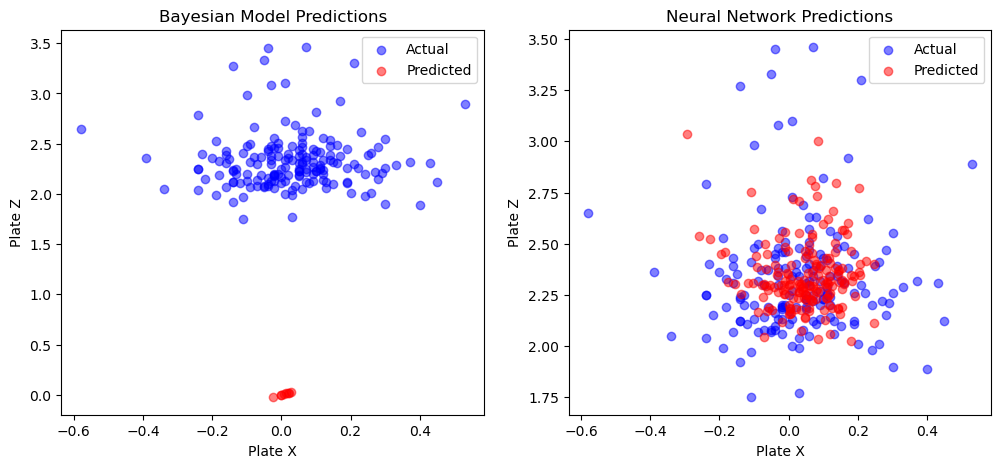

Neural Network Test MAE: 0.15612442791461945


In [35]:
# Compare the performance of the two models
plt.figure(figsize=(12, 5))

# Bayesian Model Predictions
plt.subplot(1, 2, 1)
plt.scatter(y_test["plate_x"], y_test["plate_z"], label="Actual", alpha=0.5, color='blue')
plt.scatter(trace.posterior["beta_1"].mean(dim=["chain", "draw"]),
            trace.posterior["beta_1"].mean(dim=["chain", "draw"]),
            label="Predicted", alpha=0.5, color='red')
plt.title("Bayesian Model Predictions")
plt.xlabel("Plate X")
plt.ylabel("Plate Z")
plt.legend()

# Neural Network Predictions
plt.subplot(1, 2, 2)
plt.scatter(y_test["plate_x"], y_test["plate_z"], label="Actual", alpha=0.5, color='blue')
plt.scatter(y_pred[:, 0], y_pred[:, 1], label="Predicted", alpha=0.5, color='red')
plt.title("Neural Network Predictions")
plt.xlabel("Plate X")
plt.ylabel("Plate Z")
plt.legend()

plt.show()

print(f"Neural Network Test MAE: {test_mae}")

In [36]:
import arviz as az
import numpy as np

# Extract Bayesian Coefficients from Trace
beta_means = trace.posterior["beta_1"].mean(dim=["chain", "draw"]).values

# Get absolute values to rank feature importance
feature_importance = np.abs(beta_means)

# Rank Features by Importance
top_features_idx = np.argsort(feature_importance)[-5:]  # Select Top 5 Most Important Features

# Use stored feature names
selected_features = [feature_names[i] for i in top_features_idx]

print("Selected Features for Neural Network:", selected_features)

Selected Features for Neural Network: ['release_extension', 'api_break_z_with_gravity', 'velocity', 'release_pos_x', 'spin_rate']


In [39]:
# First, recreate the model with the correct input shape
nn_model_bayesianInputs = keras.Sequential([
    layers.Input(shape=(len(selected_features),)),  # Specify correct input shape
    layers.Dense(64, activation="relu"),
    layers.Dense(64, activation="relu"),
    layers.Dense(2)  # Output layer predicting plate_x and plate_z
])

# Compile the model
nn_model_bayesianInputs.compile(optimizer="adam", loss="mse", metrics=["mae"])

# Train the model with selected features
history = nn_model_bayesianInputs.fit(
    X_train_scaled, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

# Evaluate on Test Set
test_loss, test_mae = nn_model_bayesianInputs.evaluate(X_test_scaled, y_test, verbose=0)

# Predict Pitch Locations
y_pred = nn_model_bayesianInputs.predict(X_test_scaled)

print(f"Neural Network Bayesian Inputs MAE: {test_mae}")

Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.1278 - mae: 1.3295 - val_loss: 1.6129 - val_mae: 0.9717
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.2504 - mae: 0.8409 - val_loss: 0.5121 - val_mae: 0.5352
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3997 - mae: 0.4613 - val_loss: 0.2298 - val_mae: 0.3408
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1963 - mae: 0.3137 - val_loss: 0.1929 - val_mae: 0.3088
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1553 - mae: 0.2811 - val_loss: 0.1641 - val_mae: 0.2881
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1515 - mae: 0.2777 - val_loss: 0.1520 - val_mae: 0.2785
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1391 - mae: 0.2680 - val_loss: 0.1404 - val_mae: 0.2677
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1240 - mae: 0.2469 - val_loss: 0.1309 - val_mae: 0.2588
Epoch 9/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.110

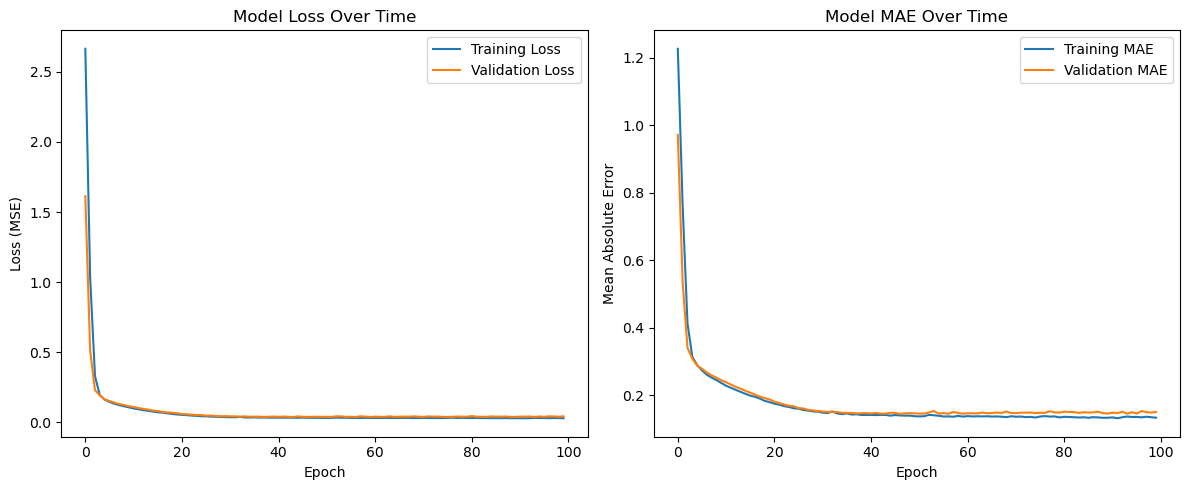


Final Training Metrics:
Training Loss: 0.0294
Validation Loss: 0.0426
Training MAE: 0.1335
Validation MAE: 0.1504


In [40]:
# Plot training history
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()

# MAE plot
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE Over Time')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()

plt.tight_layout()
plt.show()

# Print final metrics
print("\nFinal Training Metrics:")
print(f"Training Loss: {history.history['loss'][-1]:.4f}")
print(f"Validation Loss: {history.history['val_loss'][-1]:.4f}")
print(f"Training MAE: {history.history['mae'][-1]:.4f}")
print(f"Validation MAE: {history.history['val_mae'][-1]:.4f}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


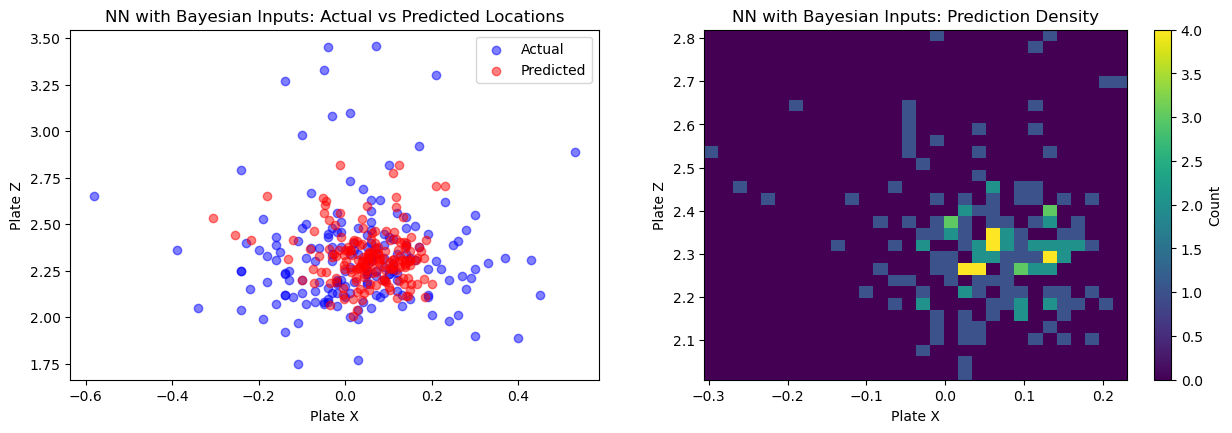

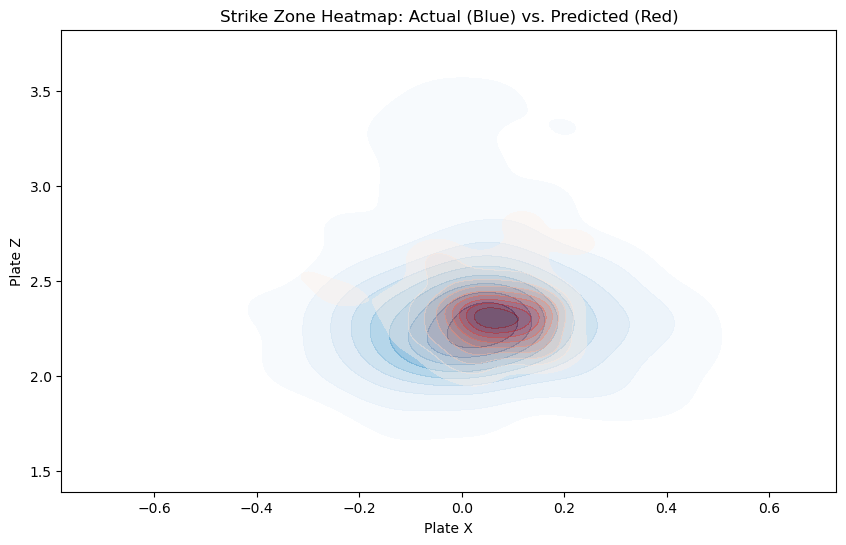

<Figure size 640x480 with 0 Axes>


Neural Network with Bayesian Inputs Prediction Statistics:
X-coordinate MAE: 0.1279
Z-coordinate MAE: 0.1697


In [56]:
# Get predictions from the NN model with Bayesian inputs
nn_predictions = nn_model_bayesianInputs.predict(X_test_scaled)

plt.figure(figsize=(15, 10))


plt.subplot(2, 2, 1)
plt.scatter(y_test['plate_x'], y_test['plate_z'],
           alpha=0.5, label='Actual', color='blue')
plt.scatter(nn_predictions[:, 0], nn_predictions[:, 1],
           alpha=0.5, label='Predicted', color='red')
plt.title('NN with Bayesian Inputs: Actual vs Predicted Locations')
plt.xlabel('Plate X')
plt.ylabel('Plate Z')
plt.legend()


plt.subplot(2, 2, 2)
plt.hist2d(nn_predictions[:, 0], nn_predictions[:, 1], bins=30, cmap='viridis')
plt.colorbar(label='Count')
plt.title('NN with Bayesian Inputs: Prediction Density')
plt.xlabel('Plate X')
plt.ylabel('Plate Z')

plt.figure(figsize=(10, 6))

# Generate KDE plot
sns.kdeplot(x=y_test["plate_x"], y=y_test["plate_z"], cmap="Blues", fill=True, alpha=0.6)
sns.kdeplot(x=y_pred[:, 0], y=y_pred[:, 1], cmap="Reds", fill=True, alpha=0.4)

plt.title("Strike Zone Heatmap: Actual (Blue) vs. Predicted (Red)")
plt.xlabel("Plate X")
plt.ylabel("Plate Z")
plt.show()

plt.tight_layout()
plt.show()

# Print prediction statistics
print("\nNeural Network with Bayesian Inputs Prediction Statistics:")
print(f"X-coordinate MAE: {np.mean(np.abs(y_test['plate_x'] - nn_predictions[:, 0])):.4f}")
print(f"Z-coordinate MAE: {np.mean(np.abs(y_test['plate_z'] - nn_predictions[:, 1])):.4f}")

Bayesian model shows poor performane as it is not able to capture the non-linear relationship between the features and the target variables.
The NN model shows better performance as it is able to capture the non-linear relationship between the features and the target variables.
Lets visaulize the pitch movement and location

- Makes sense as the actual and predicted pitch locations are close to each other (center of the zone).
- Let's use other features from the batter's perspective to see if we can improve the model.

# Is LSTM better than the previous NN model?
# Selected features (Pitcher + Batter)

In [49]:
# Selected features (Pitcher + Batter)
features = [
    'velocity', 'spin_rate', 'release_extension', 'arm_angle',
    'api_break_z_with_gravity', 'api_break_x_arm',
    'release_pos_x', 'release_pos_z',

    # Batter-related features
    'swing_miss_percent', 'woba', 'xwoba', 'hardhit_percent',
    'barrels_per_bbe_percent', 'obp', 'batter_run_value_per_100'
]

# Target Variables
targets = ['plate_x', 'plate_z']

# Drop missing values
df = df.dropna(subset=features + targets)

# Feature selection
X = df[features]
y = df[targets]

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

print(f"Training Samples: {X_train.shape[0]}, Testing Samples: {X_test.shape[0]}")

Training Samples: 689, Testing Samples: 173


Epoch 1/50


/Users/ankush/miniforge3/envs/baseball/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 2.8183 - mae: 1.2995 - val_loss: 2.4581 - val_mae: 1.1708
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.9629 - mae: 1.0741 - val_loss: 2.1646 - val_mae: 1.1020
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.2937 - mae: 0.8753 - val_loss: 1.8353 - val_mae: 1.0195
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6247 - mae: 0.6132 - val_loss: 1.5416 - val_mae: 0.9409
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2486 - mae: 0.3762 - val_loss: 1.3284 - val_mae: 0.8775
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1576 - mae: 0.2966 - val_loss: 1.2197 - val_mae: 0.8412
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1445 - mae: 0.2715 - val_loss: 1.1662 - val_mae: 0.8225
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1014 - mae: 0.2409 - val_loss: 1.1421 - val_mae: 0.8139
Epoch 9/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0905 - mae: 0.2233 - v

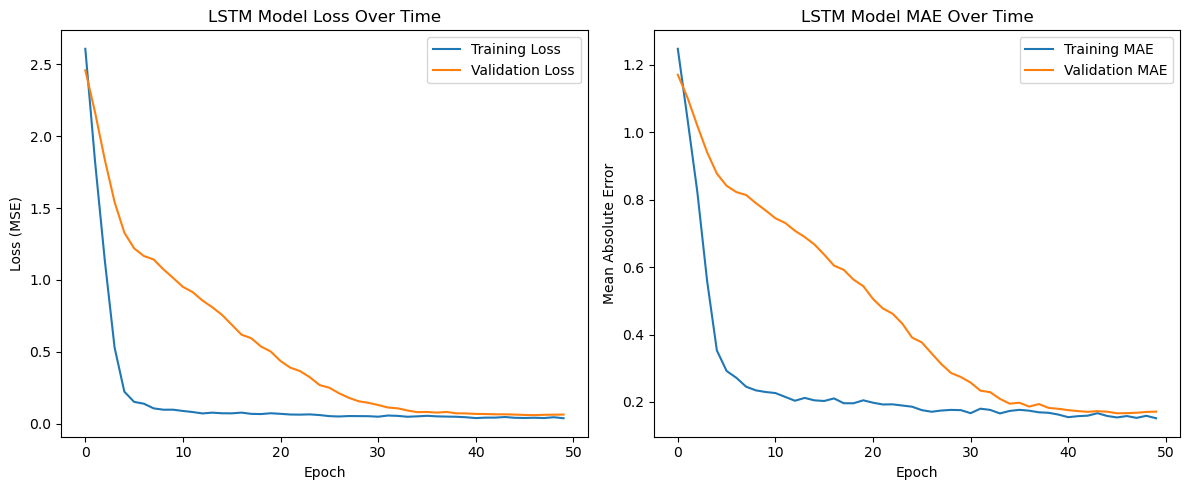


Final LSTM Training Metrics:
Training Loss: 0.0382
Validation Loss: 0.0639
Training MAE: 0.1515
Validation MAE: 0.1712


In [50]:
# Using LSTM instead of Sequential model to capture sequence game types
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, BatchNormalization

# Reshape data for LSTM (adding time dimension)
X_train_reshaped = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_reshaped = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Define LSTM-based Neural Network
nn_lstm = Sequential([
    LSTM(64, activation="relu", return_sequences=True, input_shape=(1, X_train.shape[1])),
    Dropout(0.2),
    LSTM(32, activation="relu"),
    BatchNormalization(),
    Dense(16, activation="relu"),
    Dense(2)  # Output: Predicting (plate_x, plate_z)
])

# Compile Model
nn_lstm.compile(optimizer="adam", loss="mse", metrics=["mae"])

# Train Model and store history
history_lstm = nn_lstm.fit(
    X_train_reshaped,
    y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

# Plot training history for LSTM
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(history_lstm.history['loss'], label='Training Loss')
plt.plot(history_lstm.history['val_loss'], label='Validation Loss')
plt.title('LSTM Model Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()

# MAE plot
plt.subplot(1, 2, 2)
plt.plot(history_lstm.history['mae'], label='Training MAE')
plt.plot(history_lstm.history['val_mae'], label='Validation MAE')
plt.title('LSTM Model MAE Over Time')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()

plt.tight_layout()
plt.show()

# Print final metrics
print("\nFinal LSTM Training Metrics:")
print(f"Training Loss: {history_lstm.history['loss'][-1]:.4f}")
print(f"Validation Loss: {history_lstm.history['val_loss'][-1]:.4f}")
print(f"Training MAE: {history_lstm.history['mae'][-1]:.4f}")
print(f"Validation MAE: {history_lstm.history['val_mae'][-1]:.4f}")

# LSTM Model Predictions are not necessarily better than the previous NN model as we can see from the plots there is overfitting.
# add regularization to the model

Epoch 1/100


/Users/ankush/miniforge3/envs/baseball/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 3.9465 - mae: 1.2666 - val_loss: 3.6250 - val_mae: 1.2033 - learning_rate: 0.0010
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.6064 - mae: 1.2114 - val_loss: 3.4226 - val_mae: 1.1764 - learning_rate: 0.0010
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.2662 - mae: 1.1456 - val_loss: 3.2172 - val_mae: 1.1462 - learning_rate: 0.0010
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.9965 - mae: 1.1003 - val_loss: 3.0096 - val_mae: 1.1125 - learning_rate: 0.0010
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.7510 - mae: 1.0579 - val_loss: 2.8008 - val_mae: 1.0754 - learning_rate: 0.0010
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.4865 - mae: 1.0056 - val_loss: 2.5908 - val_mae: 1.0346 - learning_rate: 0.0010
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.2129 - mae: 0.9354 - val_loss: 2.3839 - val_mae: 0.9911 - learning_rate: 0.0010
Epoch 8/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0

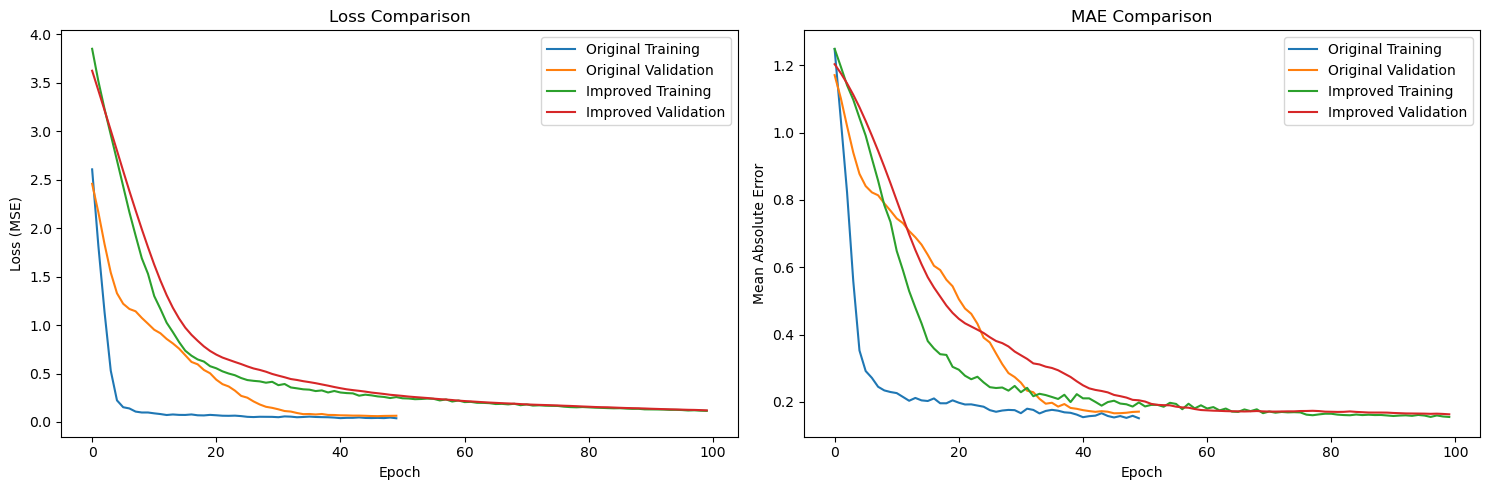


Improved LSTM Final Metrics:
Training Loss: 0.1143
Validation Loss: 0.1197
Training MAE: 0.1553
Validation MAE: 0.1632


In [51]:
# adding L2 loss to the model
# Improved LSTM model with regularization techniques
from tensorflow.keras.regularizers import l2

# Define improved LSTM-based Neural Network
nn_lstm_improved = Sequential([
    LSTM(32,
         activation="relu",
         return_sequences=True,
         input_shape=(1, X_train.shape[1]),
         kernel_regularizer=l2(0.01),  # L2 regularization
         recurrent_regularizer=l2(0.01)),
    Dropout(0.3),  # Increased dropout

    # Second LSTM layer
    LSTM(16,
         activation="relu",
         kernel_regularizer=l2(0.01)),
    Dropout(0.3),

    BatchNormalization(),

    Dense(8, activation="relu", kernel_regularizer=l2(0.01)),
    Dense(2)
])

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


nn_lstm_improved.compile(
    optimizer="adam",
    loss="mse",
    metrics=["mae"]
)

# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=0.0001
)

# Train Model with callbacks
history_lstm_improved = nn_lstm_improved.fit(
    X_train_reshaped,
    y_train,
    epochs=100,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# Plot comparison of original vs improved model
plt.figure(figsize=(15, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(history_lstm.history['loss'], label='Original Training')
plt.plot(history_lstm.history['val_loss'], label='Original Validation')
plt.plot(history_lstm_improved.history['loss'], label='Improved Training')
plt.plot(history_lstm_improved.history['val_loss'], label='Improved Validation')
plt.title('Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()

# MAE plot
plt.subplot(1, 2, 2)
plt.plot(history_lstm.history['mae'], label='Original Training')
plt.plot(history_lstm.history['val_mae'], label='Original Validation')
plt.plot(history_lstm_improved.history['mae'], label='Improved Training')
plt.plot(history_lstm_improved.history['val_mae'], label='Improved Validation')
plt.title('MAE Comparison')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()

plt.tight_layout()
plt.show()

# Print final metrics
print("\nImproved LSTM Final Metrics:")
print(f"Training Loss: {history_lstm_improved.history['loss'][-1]:.4f}")
print(f"Validation Loss: {history_lstm_improved.history['val_loss'][-1]:.4f}")
print(f"Training MAE: {history_lstm_improved.history['mae'][-1]:.4f}")
print(f"Validation MAE: {history_lstm_improved.history['val_mae'][-1]:.4f}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


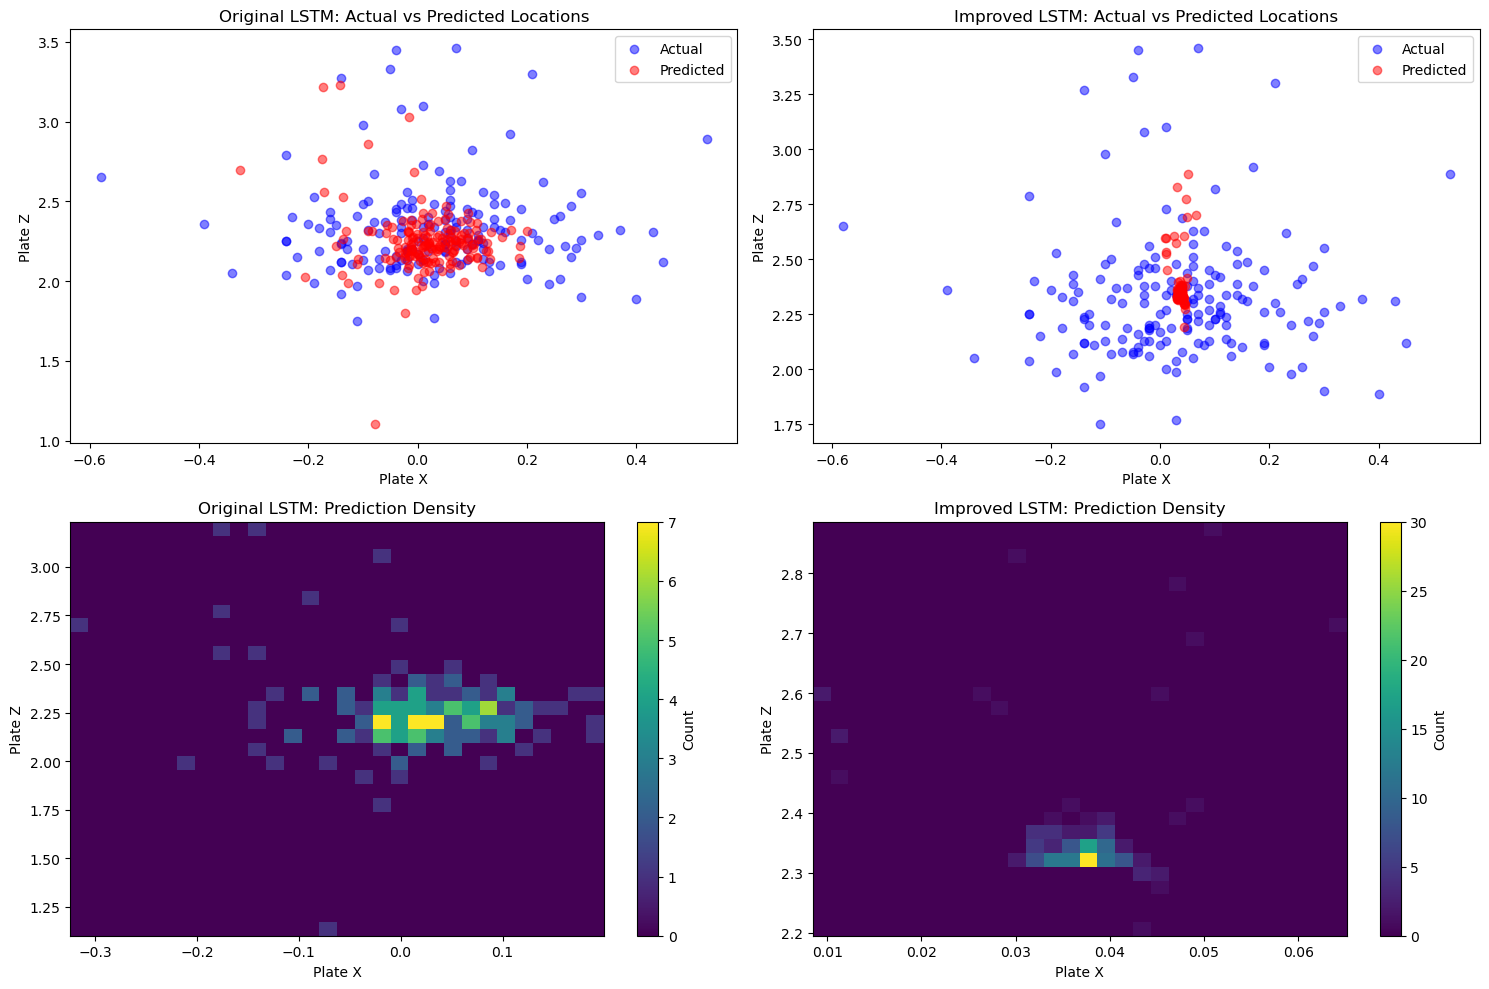


Prediction Statistics:

Original LSTM:
X-coordinate MAE: 0.1267
Z-coordinate MAE: 0.1989

Improved LSTM:
X-coordinate MAE: 0.1191
Z-coordinate MAE: 0.1895


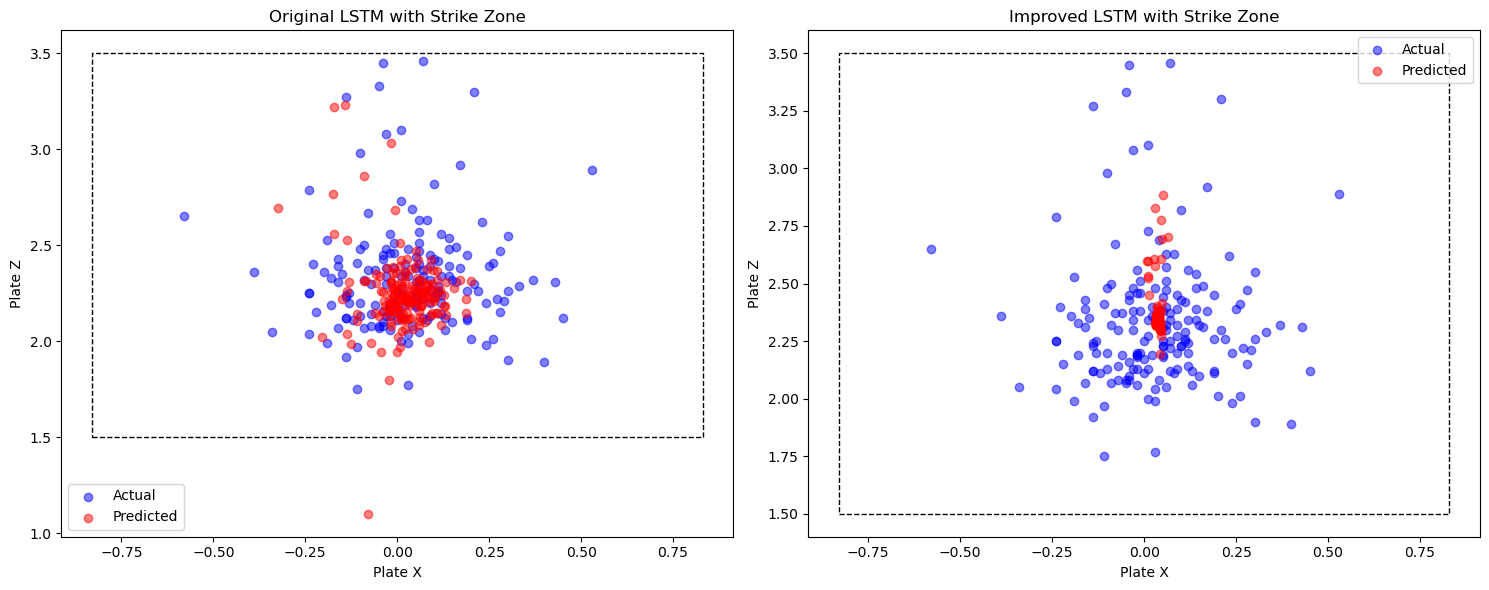

In [ ]:

# Get predictions from both models
original_preds = nn_lstm.predict(X_test_reshaped)
improved_preds = nn_lstm_improved.predict(X_test_reshaped)


plt.figure(figsize=(15, 10))

# Plot 1: Original LSTM predictions
plt.subplot(2, 2, 1)
plt.scatter(y_test['plate_x'], y_test['plate_z'],
           alpha=0.5, label='Actual', color='blue')
plt.scatter(original_preds[:, 0], original_preds[:, 1],
           alpha=0.5, label='Predicted', color='red')
plt.title('Original LSTM: Actual vs Predicted Locations')
plt.xlabel('Plate X')
plt.ylabel('Plate Z')
plt.legend()

# Plot 2: Improved LSTM predictions
plt.subplot(2, 2, 2)
plt.scatter(y_test['plate_x'], y_test['plate_z'],
           alpha=0.5, label='Actual', color='blue')
plt.scatter(improved_preds[:, 0], improved_preds[:, 1],
           alpha=0.5, label='Predicted', color='red')
plt.title('Improved LSTM: Actual vs Predicted Locations')
plt.xlabel('Plate X')
plt.ylabel('Plate Z')
plt.legend()

# Plot 3: Original LSTM prediction heatmap
plt.subplot(2, 2, 3)
plt.hist2d(original_preds[:, 0], original_preds[:, 1], bins=30, cmap='viridis')
plt.colorbar(label='Count')
plt.title('Original LSTM: Prediction Density')
plt.xlabel('Plate X')
plt.ylabel('Plate Z')

# Plot 4: Improved LSTM prediction heatmap
plt.subplot(2, 2, 4)
plt.hist2d(improved_preds[:, 0], improved_preds[:, 1], bins=30, cmap='viridis')
plt.colorbar(label='Count')
plt.title('Improved LSTM: Prediction Density')
plt.xlabel('Plate X')
plt.ylabel('Plate Z')

plt.tight_layout()
plt.show()

# Print prediction statistics
print("\nPrediction Statistics:")
print("\nOriginal LSTM:")
print(f"X-coordinate MAE: {np.mean(np.abs(y_test['plate_x'] - original_preds[:, 0])):.4f}")
print(f"Z-coordinate MAE: {np.mean(np.abs(y_test['plate_z'] - original_preds[:, 1])):.4f}")

print("\nImproved LSTM:")
print(f"X-coordinate MAE: {np.mean(np.abs(y_test['plate_x'] - improved_preds[:, 0])):.4f}")
print(f"Z-coordinate MAE: {np.mean(np.abs(y_test['plate_z'] - improved_preds[:, 1])):.4f}")

# Optional: Add strike zone rectangle to the scatter plots
def add_strike_zone(ax):
    # Approximate strike zone dimensions
    zone_left = -0.83
    zone_right = 0.83
    zone_top = 3.5
    zone_bottom = 1.5

    rectangle = plt.Rectangle((zone_left, zone_bottom),
                            zone_right - zone_left,
                            zone_top - zone_bottom,
                            fill=False, color='black', linestyle='--')
    ax.add_patch(rectangle)

# Add strike zones to the scatter plots
plt.figure(figsize=(15, 6))

# Original LSTM with strike zone
plt.subplot(1, 2, 1)
plt.scatter(y_test['plate_x'], y_test['plate_z'],
           alpha=0.5, label='Actual', color='blue')
plt.scatter(original_preds[:, 0], original_preds[:, 1],
           alpha=0.5, label='Predicted', color='red')
add_strike_zone(plt.gca())
plt.title('Original LSTM with Strike Zone')
plt.xlabel('Plate X')
plt.ylabel('Plate Z')
plt.legend()

# Improved LSTM with strike zone
plt.subplot(1, 2, 2)
plt.scatter(y_test['plate_x'], y_test['plate_z'],
           alpha=0.5, label='Actual', color='blue')
plt.scatter(improved_preds[:, 0], improved_preds[:, 1],
           alpha=0.5, label='Predicted', color='red')
add_strike_zone(plt.gca())
plt.title('Improved LSTM with Strike Zone')
plt.xlabel('Plate X')
plt.ylabel('Plate Z')
plt.legend()

plt.tight_layout()
plt.show()

# Think of a better way to improve the model. Use Bayesian Neural Network??